# Decision Trees Exercise

## Exercise 1
Find some data on people. The goal is to decide if someone buys a computer or not. Derive the best decision tree by calculating a little by hand (Shannon). At least the first split. 


In [692]:
import pandas as pd
from sklearn import preprocessing
from collections import Counter
import math
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz


df = pd.read_csv("data/computer.csv")
df

,rec,age,income,student,credit_rating,buys_computer
0,r1,<=30,High,No,Fair,No
1,r2,<=30,High,No,Excellent,No
2,r3,31...40,High,No,Fair,Yes
3,r4,>40,Medium,No,Fair,Yes
4,r5,>40,Low,Yes,Fair,Yes
5,r6,>40,Low,Yes,Excellent,No
6,r7,31...40,Low,Yes,Excellent,Yes
7,r8,<=30,Medium,No,Fair,No
8,r9,<=30,Low,Yes,Fair,Yes
9,r10,>40,Medium,Yes,Fair,Yes


### Prepare the dataset

In [693]:
df = df.drop("rec",axis=1)
df 

,age,income,student,credit_rating,buys_computer
0,<=30,High,No,Fair,No
1,<=30,High,No,Excellent,No
2,31...40,High,No,Fair,Yes
3,>40,Medium,No,Fair,Yes
4,>40,Low,Yes,Fair,Yes
5,>40,Low,Yes,Excellent,No
6,31...40,Low,Yes,Excellent,Yes
7,<=30,Medium,No,Fair,No
8,<=30,Low,Yes,Fair,Yes
9,>40,Medium,Yes,Fair,Yes


In [694]:
# age feature
df.replace("<=30",0,inplace=True)
df.replace("31...40",1,inplace=True)
df.replace(">40",2,inplace=True)

# income feature
df.replace("Low",0,inplace=True)
df.replace("Medium",1,inplace=True)
df.replace("High",2,inplace=True)

# student feature
df.replace("No",0,inplace=True)
df.replace("Yes",1,inplace=True)

# credit_rating feature
df.replace("Fair",0,inplace=True)
df.replace("Excellent",1,inplace=True)

df

,age,income,student,credit_rating,buys_computer
0,0,2,0,0,0
1,0,2,0,1,0
2,1,2,0,0,1
3,2,1,0,0,1
4,2,0,1,0,1
5,2,0,1,1,0
6,1,0,1,1,1
7,0,1,0,0,0
8,0,0,1,0,1
9,2,1,1,0,1


### Implement the algorithm with the shannon entropy

In [695]:
def calcShannonEntropy(truthy, falsy):
    total = truthy + falsy
    truthy_prob = truthy / total
    falsy_prob = falsy / total
    probs = [truthy_prob, falsy_prob]
    entropy = 0.0
    for prob in probs:
        if prob > 0:
            entropy -= prob * math.log(prob,2)
    
    return entropy

In [696]:
def determineEntropyForFeatureValue(dataSet, feature, value):
    with_value = dataSet.loc[dataSet[feature] == value, ["buys_computer"]]
    c = Counter(with_value["buys_computer"])
    return calcShannonEntropy(c[0],c[1])

In [697]:
def calcEntropyOfFeature(dataSet, feature):
    cf = Counter(dataSet[feature])
    feature_entropy = 0.0
    feature_range = list(cf)
    
    for value in feature_range:
        entropy = determineEntropyForFeatureValue(dataSet, feature, value)
        with_value = dataSet.loc[dataSet[feature] == value, ["buys_computer"]]
        prob = len(with_value) / len(dataSet)
        feature_entropy += prob * entropy

    return feature_entropy
        
    
    

In [698]:
def calcInformationGainForFeature(dataSet, feature):
    c = Counter(dataSet["buys_computer"])
    base_entropy = calcShannonEntropy(c[0],c[1])
    feature_entropy = calcEntropyOfFeature(dataSet, feature)
    return base_entropy - feature_entropy

In [699]:
def getBestFeatureToSplit(dataSet):
    informationGainPerFeature = {}
    for feature in dataSet.columns[:-1]:
        informationGainPerFeature[feature] = calcInformationGainForFeature(dataSet, feature)
    
    sorted_tuples = sorted(informationGainPerFeature.items(), reverse=True, key=lambda item: item[1])
    sorted_dict = {k: v for k, v in sorted_tuples}
    return next(iter(sorted_dict.keys()))
    

In [700]:
getBestFeatureToSplit(df)

'age'

In [701]:
def buildTree(dataSet, tree):
    if(len(dataSet.columns) < 2):
        return tree
    
    split_feature = getBestFeatureToSplit(dataSet)
    feature_range = list(Counter(dataSet[split_feature]))
    tree[split_feature] = {}
    for value in feature_range: 
        entropy = determineEntropyForFeatureValue(dataSet,split_feature,value)
        if entropy == 0:
            ds = dataSet.loc[dataSet[split_feature] == value,"buys_computer"]
            result = ds.iloc[0]
            tree[split_feature][value] = result;
        else:
            new_data = dataSet.drop(split_feature, axis=1)
            new_tree = buildTree(new_data, {})
            if new_tree == {}: 
                leaf_data = dataSet.loc[dataSet[split_feature] == value,"buys_computer"]
                c = Counter(leaf_data)
                truthy_prob = c[1] / len(leaf_data)
                falsy_prob = c[0] / len(leaf_data)
                new_tree = {
                    1: truthy_prob,
                    0: falsy_prob
                }
                
            tree[split_feature][value] = buildTree(new_data, new_tree)
    
    return tree

### Let's try it out

In [702]:
tree = buildTree(df, {})
tree

{'age': {0: {'student': {0: {'credit_rating': {0: {'income': {2: {1: 0.6,
         0: 0.4},
        1: {1: 0.625, 0: 0.375},
        0: {1: 0.5714285714285714, 0: 0.42857142857142855}}},
      1: {'income': {2: {1: 0.6, 0: 0.4},
        1: {1: 0.625, 0: 0.375},
        0: {1: 0.5714285714285714, 0: 0.42857142857142855}}}}},
    1: {'credit_rating': {0: {'income': {2: {1: 0.6, 0: 0.4},
        1: {1: 0.625, 0: 0.375},
        0: {1: 0.5714285714285714, 0: 0.42857142857142855}}},
      1: {'income': {2: {1: 0.6, 0: 0.4},
        1: {1: 0.625, 0: 0.375},
        0: {1: 0.5714285714285714, 0: 0.42857142857142855}}}}}}},
  1: 1,
  2: {'student': {0: {'credit_rating': {0: {'income': {2: {1: 0.6, 0: 0.4},
        1: {1: 0.625, 0: 0.375},
        0: {1: 0.5714285714285714, 0: 0.42857142857142855}}},
      1: {'income': {2: {1: 0.6, 0: 0.4},
        1: {1: 0.625, 0: 0.375},
        0: {1: 0.5714285714285714, 0: 0.42857142857142855}}}}},
    1: {'credit_rating': {0: {'income': {2: {1: 0.6, 0: 0.

That's the tree :) The first split is for example the age feature.

## Exercise 2 - Scikit learn 


In [703]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

tree_clf = DecisionTreeClassifier(max_depth=5)
tree_clf.fit(x, y)


DecisionTreeClassifier(max_depth=5)

In [704]:
export_graphviz(
         tree_clf,
         out_file="computer_tree.dot",
         feature_names=df.columns[:-1],
         rounded=True,
         filled=True
 )


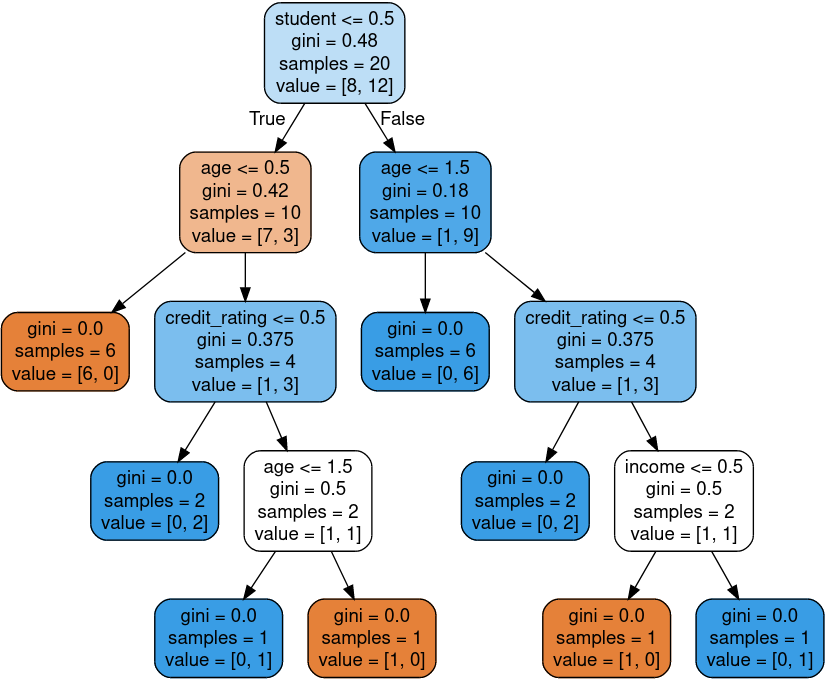

The trees are in fact completely different. The most obvious reason is that they are built with different algorithms. My tree is based on the *information gain* and the scikit one on the *Gini index*. 
The 